# Predictive Modeling for Diabetes using ML Classifiers 🩺

# 1. Problem Definition

## 1.1 Project Goal

## 1.2 Problem Statement

## 1.3 Impact of the Solution

# 2. Data Collection


## 2.1 Source of Data


## 2.2 Composition of the Dataset


# 3. Data Preproccesing

In [ ]:
# Data Manipulation and Visualization
import pandas as pd
import numpy as np
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate, plot_slice

# Utilities
import os
import time
import pickle

# Google Colab and Paths
# from google.colab import drive
# drive.mount('/content/drive')
dataset_path = 'diabetes_dataset.csv'
save_dir = '/optuna_studies'

## 3.1 Loading the Dataset and Handling Missing Values

In [2]:
df = pd.read_csv(dataset_path)

print("Initial few rows of the dataset:")
print(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Initial few rows of the dataset:
   year  gender   age location  race:AfricanAmerican  race:Asian  \
0  2020  Female  32.0  Alabama                     0           0   
1  2015  Female  29.0  Alabama                     0           1   
2  2015    Male  18.0  Alabama                     0           0   
3  2015    Male  41.0  Alabama                     0           0   
4  2016  Female  52.0  Alabama                     1           0   

   race:Caucasian  race:Hispanic  race:Other  hypertension  heart_disease  \
0               0              0           1             0              0   
1               0              0           0             0              0   
2               0              0           1             0              0   
3               1              0           0             0              0   
4               0              0           0             0              0   

  smoking_history    bmi  hbA1c_level  blood_glucose_level  diabetes  
0           never  27.32

## 3.2 Encoding Categorical Variables

In [3]:
# Binary encoding for gender and location
binary_encoder = OneHotEncoder(drop='if_binary', sparse_output=False)
binary_encoded = binary_encoder.fit_transform(df[['gender', 'location']])
binary_encoded_df = pd.DataFrame(binary_encoded, columns=binary_encoder.get_feature_names_out(['gender', 'location']))
df = pd.concat([df, binary_encoded_df], axis=1)
df.drop(columns=['gender', 'location'], inplace=True)

# Since smoking_history has multiple categories, we will use label encoding
label_encoder = LabelEncoder()
df['smoking_history'] = label_encoder.fit_transform(df['smoking_history'])

## 3.3 Standardizating Numerical Variables

In [4]:
scaler = StandardScaler()
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
df[num_features] = scaler.fit_transform(df[num_features])

## 3.4 Handling Class Imbalance using SMOTE

In [5]:
# Split the features from the label
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution before and after applying SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution before SMOTE:
diabetes
0    73200
1     6800
Name: count, dtype: int64

Class distribution after SMOTE:
diabetes
0    73200
1    73200
Name: count, dtype: int64


# 4. Exploratory Data Analysis (EDA)

## 4.1 Descriptive Statistics: Summary Statistics for Numerical Features

In [6]:
# Reload the original dataset for EDA
df_original = pd.read_csv('diabetes_dataset.csv')

summary_stats = df_original.describe()
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
                 year            age  race:AfricanAmerican     race:Asian  \
count  100000.000000  100000.000000         100000.000000  100000.000000   
mean     2018.360820      41.885856              0.202230       0.200150   
std         1.345239      22.516840              0.401665       0.400114   
min      2015.000000       0.080000              0.000000       0.000000   
25%      2019.000000      24.000000              0.000000       0.000000   
50%      2019.000000      43.000000              0.000000       0.000000   
75%      2019.000000      60.000000              0.000000       0.000000   
max      2022.000000      80.000000              1.000000       1.000000   

       race:Caucasian  race:Hispanic     race:Other  hypertension  \
count   100000.000000   100000.00000  100000.000000  100000.00000   
mean         0.198760        0.19888       0.199980       0.07485   
std          0.399069        0.39916       0.399987       0.26315   
min          0.000

## 4.2 Data Visualization

### 4.2.1 Heatmap of features correlation

In [ ]:
plt.figure(figsize=(12, 8))
# Select only numeric columns for correlation matrix
numeric_cols = df_original.select_dtypes(include=[np.number]).columns
correlation_matrix = df_original[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

![Heatmap](https://i.imgur.com/zO0I1ZR.png)

### 4.2.2 Class Distribution

In [ ]:
# Check for class imbalance in the target variable
class_counts = df_original['diabetes'].value_counts()
print("Class distribution in the target variable (diabetes):\n", class_counts)

plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes', data=df_original)
plt.title('Class Distribution of Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Count')
plt.show()

![Distribution](https://i.imgur.com/aBW9RPS.png)

Since class imbalance is found, SMOTE will be applied in the preprocessing.

### 4.2.3 Distribution of Numerical Features

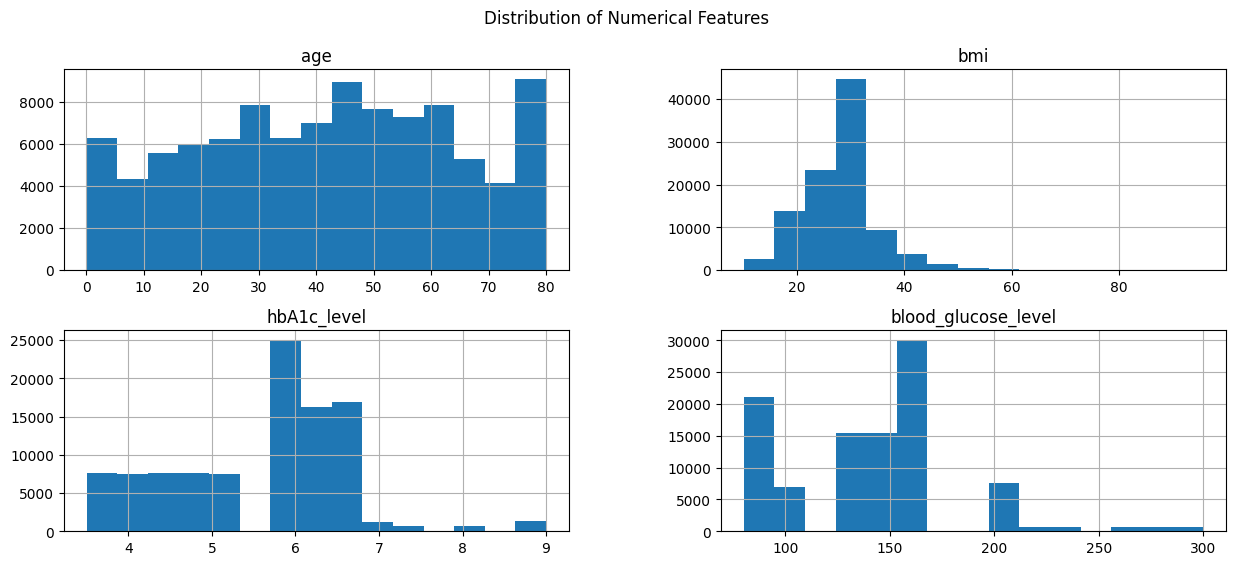

In [9]:
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
df_original[num_features].hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.suptitle('Distribution of Numerical Features')
plt.show()

![Numericals](https://i.imgur.com/JUgm16j.png)

# 5. Feature Engineering

## 5.1 Removing Features with Low Correlation with Diabetes

In [10]:
# Check the first few rows of the dataset after preprocessing
pd.set_option('display.max_columns', None)
print("First few rows of the preprocessed dataset:")
print(X_train_smote.head())


First few rows of the preprocessed dataset:
   year       age  race:AfricanAmerican  race:Asian  race:Caucasian  \
0  2018  0.138304                     1           0               0   
1  2016 -0.838748                     0           0               0   
2  2019  0.449184                     1           0               0   
3  2019  0.760064                     0           0               0   
4  2016 -0.749925                     0           1               0   

   race:Hispanic  race:Other  hypertension  heart_disease  smoking_history  \
0              0           0             0              0                1   
1              0           1             1              0                0   
2              0           0             0              0                5   
3              0           1             0              0                4   
4              0           0             0              0                3   

        bmi  hbA1c_level  blood_glucose_level  gender_Female

In [15]:
# Remove the 'year', 'race', and 'location_' columns
columns_to_remove = ['year']+ [col for col in X.columns if col.startswith('race:')] + [col for col in X.columns if col.startswith('location_')]
X_train_cleaned = X_train_smote.drop(columns=columns_to_remove)
X_test_cleaned = X_test.drop(columns=columns_to_remove)

print(X_train_cleaned.head())

        age  hypertension  heart_disease  smoking_history       bmi  \
0  0.138304             0              0                1  0.953664   
1 -0.838748             1              0                0  0.477528   
2  0.449184             0              0                5 -0.000116   
3  0.760064             0              0                4  2.407689   
4 -0.749925             0              0                3 -1.002112   

   hbA1c_level  blood_glucose_level  gender_Female  gender_Male  gender_Other  
0    -1.893686            -1.180558            0.0          1.0           0.0  
1    -0.679490             1.521618            1.0          0.0           0.0  
2    -0.492690            -0.197948            1.0          0.0           0.0  
3     3.056500             0.047704            1.0          0.0           0.0  
4    -0.492690             0.489878            1.0          0.0           0.0  


# 6. Model Selection & Training

## 6.1 Logistic Regression Classifier

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=log_reg_param_grid, cv=5, n_jobs=-1, scoring='f1')

grid_search.fit(X_train_cleaned, y_train_smote)

# Get the best estimator
best_log_reg = grid_search.best_estimator_

y_pred = best_log_reg.predict(X_test_cleaned)
print(classification_report(y_test, y_pred))

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18300
           1       0.41      0.87      0.56      1700

    accuracy                           0.88     20000
   macro avg       0.70      0.88      0.75     20000
weighted avg       0.94      0.88      0.90     20000

Best parameters found:  {'C': 0.01, 'solver': 'liblinear'}
Best cross-validation score:  0.886275468881269


## 6.2 K-Nearest Neighbors Classifier

In [ ]:
knn = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7, 11, 21, 41],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=5, n_jobs=-1, scoring='f1')

grid_search.fit(X_train_cleaned, y_train_smote)

best_knn = grid_search.best_estimator_

y_pred = best_knn.predict(X_test_cleaned)
print(classification_report(y_test, y_pred))

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     18300
           1       0.54      0.79      0.64      1700

    accuracy                           0.93     20000
   macro avg       0.76      0.86      0.80     20000
weighted avg       0.94      0.93      0.93     20000

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score:  0.9467395686567859


## 6.3 RandomForest Classifier

In [ ]:
rf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, scoring='f1')

grid_search.fit(X_train_cleaned, y_train_smote)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_cleaned)
print(classification_report(y_test, y_pred))

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18300
           1       0.79      0.74      0.76      1700

    accuracy                           0.96     20000
   macro avg       0.88      0.86      0.87     20000
weighted avg       0.96      0.96      0.96     20000

Best parameters found:  {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score:  0.9729655120292324


In [ ]:
## 6.4 XGBoost Classifier

In [ ]:
xgb_param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(4, 8),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.2),
    'min_child_weight': randint(1, 5),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(1, 1)
}

# RandomizedSearchCV object because the hypp. space is too big
random_search_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_dist, n_iter=100, cv=5, n_jobs=-1, scoring='f1', random_state=42)

random_search_xgb.fit(X_train_cleaned, y_train_smote)

best_xgb = random_search_xgb.best_estimator_

y_pred_xgb = best_xgb.predict(X_test_cleaned)
print(classification_report(y_test, y_pred_xgb))

print("Best parameters found: ", random_search_xgb.best_params_)
print("Best cross-validation score: ", random_search_xgb.best_score_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:25:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.94      0.71      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.95      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Best parameters found:  {'colsample_bytree': 0.6448155608672209, 'gamma': 0.07957111980914833, 'learning_rate': 0.10694704332753689, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 233, 'reg_alpha': 0.09750671629451425, 'reg_lambda': 1.4907487792587846, 'subsample': 0.8891584386487102}
Best cross-validation score:  0.9760651261380138


In [ ]:
## 6.5 CatBoost Classifier

In [ ]:
# Define the CatBoostClassifier
catboost = CatBoostClassifier(verbose=0)

# Define the parameter grid
catboost_param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.01, 0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=catboost, param_grid=catboost_param_grid, cv=5, n_jobs=-1, scoring='f1')

# Fit the model
grid_search.fit(X_train_cleaned, y_train_smote)

# Get the best estimator
best_catboost = grid_search.best_estimator_

# Evaluate the model
y_pred = best_catboost.predict(X_test_cleaned)
print(classification_report(y_test, y_pred))

# Optionally, print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.96      0.70      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.97      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000

Best parameters found:  {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best cross-validation score:  0.9769942405184306


In [ ]:
## 6.6 Gaussian Naive Bayes Classifier

In [ ]:
gnb = GaussianNB()

gnb_param_grid = {
    'var_smoothing': np.logspace(-9, -6, 4)
}

grid_search = GridSearchCV(estimator=gnb, param_grid=gnb_param_grid, cv=5, n_jobs=-1, scoring='f1')

grid_search.fit(X_train_cleaned, y_train_smote)

best_gnb = grid_search.best_estimator_

y_pred = best_gnb.predict(X_test_cleaned)
print(classification_report(y_test, y_pred))

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     18300
           1       0.24      0.94      0.39      1700

    accuracy                           0.75     20000
   macro avg       0.62      0.84      0.61     20000
weighted avg       0.93      0.75      0.80     20000

Best parameters found:  {'var_smoothing': 1e-06}
Best cross-validation score:  0.8560346281260178


## 6.7 Modular Neural Network

### 6.7.1 Defining the Hyperparamter Space and Optimizing the Neural Network

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert the data to PyTorch tensors and move them to the GPU
X_train_tensor = torch.tensor(X_train_cleaned.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_smote.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_cleaned.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# The neural network class
class DiabetesNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout_rate, activation):
        super(DiabetesNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# The objective function for Optuna (Hypp. space)
def objective(trial):
    hidden_dim = trial.suggest_categorical('hidden_dim', [32 * i for i in range(1, 9)])  # Multiples of 32 up to 32*8
    n_layers = trial.suggest_int('n_layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh'])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])

    # Activation functions
    if activation_name == 'ReLU':
        activation = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation = nn.LeakyReLU()
    elif activation_name == 'Tanh':
        activation = nn.Tanh()

    # Initialize the model
    model = DiabetesNN(input_dim=X_train_tensor.shape[1], hidden_dim=hidden_dim, output_dim=1, n_layers=n_layers, dropout_rate=dropout_rate, activation=activation).to(device)
    criterion = nn.BCEWithLogitsLoss()

    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(25): 
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_pred = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            outputs = model(X_batch).squeeze()
            preds = torch.round(torch.sigmoid(outputs))
            y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU for evaluation

    # Move y_test_tensor back to CPU for evaluation
    f1 = f1_score(y_test_tensor.cpu().numpy(), y_pred)
    return f1

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', storage=f'sqlite:///{save_dir}/example_study.db', study_name='example_study', load_if_exists=True)
study.optimize(objective, n_trials=50)

# Save the study results to a file
with open(os.path.join(save_dir, "study.pkl"), "wb") as f:
    pickle.dump(study, f)

# Load the study results from a file
with open(os.path.join(save_dir, "study.pkl"), "rb") as f:
    study = pickle.load(f)

# Display the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Function to resume the study
def resume_study(study_name, storage):
    study = optuna.load_study(study_name=study_name, storage=storage)
    study.optimize(objective, n_trials=100)
    return study

study = resume_study("example_study", f'sqlite:///{save_dir}/example_study.db')

# Training loop with gradient clipping
model.train()
for epoch in range(20):  # You can increase the number of epochs
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

### 6.7.2 Printing the best Trial

In [ ]:
study = optuna.load_study(study_name="example_study", storage=f'sqlite:///{save_dir}/example_study.db')

best_trial = study.best_trial

print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")



### 6.7.3 Visualizing Optuna Study Results

In [ ]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study).show()

# Plot parameter importances
optuna.visualization.plot_param_importances(study).show()

# Plot slice
optuna.visualization.plot_slice(study).show()

![optimization history](https://i.imgur.com/nhNQwpS.png)

![parameter importances](https://i.imgur.com/I2sv1Ho.png)

![slice](https://i.imgur.com/u7AzttY.png)

### 6.7.4 Training with the best Hyperparamters

In [6]:
hidden_dim = 192
n_layers = 3
dropout_rate = 0.1314305372015669
learning_rate = 0.007833779618038004
activation = nn.LeakyReLU()
optimizer_name = 'Adam'

# Initialize the model
model = DiabetesNN(input_dim=X_train_tensor.shape[1], hidden_dim=hidden_dim, output_dim=1, n_layers=n_layers, dropout_rate=dropout_rate, activation=activation).to(device)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# Early stopping and learning rate scheduler
early_stopping_patience = 10
lr_scheduler_patience = 3
lr_scheduler_factor = 0.1

best_val_loss = float('inf')
early_stopping_counter = 0

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_scheduler_factor, patience=lr_scheduler_patience, verbose=True)

# Training loop 
model.train()
for epoch in range(100):  # Let the Early Stopping do its work
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        train_correct += (preds == y_batch).sum().item()
        train_total += y_batch.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model
        torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

# Load the best model
model.load_state_dict(torch.load(os.path.join(save_dir, "best_model.pth")))

# Evaluation of the final model
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch).squeeze()
        preds = torch.round(torch.sigmoid(outputs))
        y_pred.extend(preds.cpu().numpy())  # Move predictions back to CPU for evaluation

accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred)  # Move y_test_tensor back to CPU for evaluation
f1 = f1_score(y_test_tensor.cpu().numpy(), y_pred)  # Move y_test_tensor back to CPU for evaluation
print("Final Model Accuracy: ", accuracy)
print("Final Model F1 Score: ", f1)

Epoch 1, Train Loss: 0.20982423800405095, Train Accuracy: 0.9009289617486339, Validation Loss: 0.20948228460550308, Validation Accuracy: 0.8706
Epoch 2, Train Loss: 0.20532176621665393, Train Accuracy: 0.90474043715847, Validation Loss: 0.16737693675756454, Validation Accuracy: 0.9138
Epoch 3, Train Loss: 0.20178510305578592, Train Accuracy: 0.9056420765027322, Validation Loss: 0.17014872615337373, Validation Accuracy: 0.9001
Epoch 4, Train Loss: 0.20158547830304813, Train Accuracy: 0.9073565573770492, Validation Loss: 0.1809004996061325, Validation Accuracy: 0.8989
Epoch 5, Train Loss: 0.19861878968551347, Train Accuracy: 0.9081625683060109, Validation Loss: 0.18872734575867653, Validation Accuracy: 0.8899
Epoch 6, Train Loss: 0.27149225724850845, Train Accuracy: 0.9079781420765027, Validation Loss: 0.23205440833568572, Validation Accuracy: 0.88315
Epoch 7, Train Loss: 0.17846242041454288, Train Accuracy: 0.9138387978142076, Validation Loss: 0.18277081608772278, Validation Accuracy: 0

# 7. Model Evaluation

In [4]:
model_results = {
    "LogisticRegression": {
        "accuracy": 0.88,
        "precision": {"class_0": 0.99, "class_1": 0.41},
        "recall": {"class_0": 0.89, "class_1": 0.87},
        "f1_score": {"class_0": 0.93, "class_1": 0.56},
        "best_cv_score": 0.886275468881269,
        "best_params": {'C': 0.01, 'solver': 'liblinear'}
    },
    "KNN": {
        "accuracy": 0.93,
        "precision": {"class_0": 0.98, "class_1": 0.54},
        "recall": {"class_0": 0.94, "class_1": 0.79},
        "f1_score": {"class_0": 0.96, "class_1": 0.64},
        "best_cv_score": 0.9467395686567859,
        "best_params": {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
    },
    "RandomForest": {
        "accuracy": 0.96,
        "precision": {"class_0": 0.98, "class_1": 0.79},
        "recall": {"class_0": 0.98, "class_1": 0.74},
        "f1_score": {"class_0": 0.98, "class_1": 0.76},
        "best_cv_score": 0.9729655120292324,
        "best_params": {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
    },
    "XGB": {
        "accuracy": 0.97,
        "precision": {"class_0": 0.97, "class_1": 0.94},
        "recall": {"class_0": 1.00, "class_1": 0.71},
        "f1_score": {"class_0": 0.98, "class_1": 0.81},
        "best_cv_score": 0.9760651261380138,
        "best_params": {'colsample_bytree': 0.6448155608672209, 'gamma': 0.07957111980914833, 'learning_rate': 0.10694704332753689, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 233, 'reg_alpha': 0.09750671629451425, 'reg_lambda': 1.4907487792587846, 'subsample': 0.8891584386487102}
    },
    "CatBoost": {
        "accuracy": 0.97,
        "precision": {"class_0": 0.97, "class_1": 0.96},
        "recall": {"class_0": 1.00, "class_1": 0.70},
        "f1_score": {"class_0": 0.99, "class_1": 0.81},
        "best_cv_score": 0.9769942405184306,
        "best_params": {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
    },
    "GaussianNB": {
        "accuracy": 0.75,
        "precision": {"class_0": 0.99, "class_1": 0.24},
        "recall": {"class_0": 0.73, "class_1": 0.94},
        "f1_score": {"class_0": 0.84, "class_1": 0.39},
        "best_cv_score": 0.8560346281260178,
        "best_params": {'var_smoothing': 1e-06}
    },
    'Neural Network': {
        'accuracy': 0.91465,
        'precision': {'class_0': 0.9888057503093148, 'class_1': 0.4988437396762471},
        'recall': {'class_0': 0.917103825136612, 'class_1': 0.888235294117647},
        'f1_score': {'class_0': 0.9516060442831629, 'class_1': 0.6388830124814894},
        'best_cv_score': 0.9769942405184306,
        'best_params': {'hidden_dim': 224, 'n_layers': 2, 'dropout_rate': 0.1314305372015669, 'learning_rate': 0.007833779618038004, 'activation': 'Tanh', 'optimizer': 'Adam'}
    }
}

# Data preparation
models = list(model_results.keys())
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
classes = ['class_0', 'class_1']

# Accuracy
accuracy = [model_results[model]['accuracy'] for model in models]

# Precision, Recall, F1-Score
precision = {cls: [model_results[model]['precision'][cls] for model in models] for cls in classes}
recall = {cls: [model_results[model]['recall'][cls] for model in models] for cls in classes}
f1_score = {cls: [model_results[model]['f1_score'][cls] for model in models] for cls in classes}

## 7.1 Accuracy

In [ ]:
# Bar Chart for Accuracy with Percentage Labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=models, y=accuracy)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Adding percentage labels
for i, acc in enumerate(accuracy):
    plt.text(i, acc + 0.005, f'{acc:.2%}', ha='center', va='bottom')

plt.show()

![Accuracy](https://i.imgur.com/ruVB6lF.png)

The **accuracy results** for the models show a range of performance:

- The highest accuracy is achieved by the **XGB** and **CatBoost** models at **0.97**.
- **RandomForest** follows closely with an accuracy of **0.96**.
- The **KNN** and **Neural Network** models also perform well, with accuracies of **0.93** and **0.91465**, respectively.
- **LogisticRegression** and **GaussianNB** have lower accuracies at **0.88** and **0.75**, respectively.

> **Important Note:** Given the **class imbalance** in the dataset, where **class 1** was underrepresented before applying **SMOTE**, **accuracy alone may not be the best metric** to evaluate model performance. Accuracy can be misleading in imbalanced datasets because it may reflect the model's ability to predict the majority class (**class 0**) correctly while failing to capture the minority class (**class 1**) effectively.

Therefore, it is crucial to also consider **precision**, **recall**, and **F1-score**, especially for **class 1**, to get a more comprehensive understanding of each model's performance.

## 7.1 F1 Score

In [ ]:
for metric, data in zip(['F1-Score'], [f1_score]):
    plt.figure(figsize=(12, 6))
    for cls in classes:
        ax = sns.barplot(x=models, y=data[cls], label=cls)
        # Adding percentage labels
        for i, value in enumerate(data[cls]):
            plt.text(i, value + 0.005, f'{value:.2%}', ha='center', va='bottom')
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.show()

![F1](https://i.imgur.com/1X22wcB.png)

- **Top Performers:**
   - **XGB** and **CatBoost** are the top-performing models in terms of both **accuracy** and **F1-score** for both classes. This indicates that these models are well-balanced and handle the class imbalance effectively.


- **RandomForest:** also performs very well, with high accuracy and F1-scores, making it a strong contender for this classification task.

- **Neural Network and KNN:** show good performance, especially in terms of accuracy and F1-score for class 0. However, their F1-scores for class 1 are lower compared to the top performers, indicating they might not handle the minority class as effectively.

- **LogisticRegression and GaussianNB:** have lower overall performance, particularly in terms of F1-score for class 1. This suggests they struggle more with the class imbalance and may not be the best choices for this dataset. Having the lowest F1 score, it can be concluded that the dataset does not follow a Gaussian distribution.

## 7.3 Precision & Recall

In [ ]:
# Heatmap for Precision & Recall
for metric, data in zip(['Precision', 'Recall'], [precision, recall]):
    df = pd.DataFrame(data, index=models)
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.T, annot=True, cmap='coolwarm')
    plt.title(f'Model {metric} Heatmap')
    plt.show()

![Precision](https://i.imgur.com/lmGSadq.png)
![Recall](https://i.imgur.com/FpgTSDI.png)

- **Precision:** Measures how many of the predicted positive instances are actually positive. High precision indicates a low false positive rate.
- **Recall:** Measures how many of the actual positive instances are correctly identified by the model. High recall indicates a low false negative rate.

**Brief Summary of Results:**

- **Class 0:** All models exhibit high precision and recall, indicating they are effective at identifying and correctly predicting the majority class.
- **Class 1:** Precision and recall vary significantly across models. **CatBoost** and **XGB** show a strong balance between precision and recall, making them reliable for handling the minority class. **RandomForest** also performs well, while **LogisticRegression** and **GaussianNB** show higher recall but lower precision, indicating a higher rate of false positives. **Neural Network** and **KNN** have moderate performance, suggesting room for improvement.

Overall, models like **CatBoost**, **XGB**, and **RandomForest** that maintain a good balance between precision and recall are preferable for effectively handling class imbalance.

## 7.4 Radar Chart for Overall Performance

In [ ]:
# Data preparation for radar chart
def get_radar_data(model_results, metrics):
    data = []
    for model in models:
        model_data = []
        for metric in metrics:
            if metric == 'accuracy':
                model_data.append(model_results[model][metric])
            else:
                model_data.append(np.mean(list(model_results[model][metric].values())))
        data.append(model_data)
    return data

radar_data = get_radar_data(model_results, metrics)

# Radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

for i, model in enumerate(models):
    values = radar_data[i]
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.25)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title('Model Performance Radar Chart')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

![Radar chart](https://i.imgur.com/yEHRslO.png)

# 8. Conclusion